# Objective
The objective of this notebook is to detect missing values and then go over some of the methods used for imputing them.



# Data

There are two publically available datasets which will be used to explain the concepts:

* 1. [Titanic Dataset](https://www.kaggle.com/c/titanic) for Non Time Series problem
* 2. [Air Quality Data in India (2015 - 2020)](https://www.kaggle.com/rohanrao/air-quality-data-in-india) for Time Series problem


# Loading necessary libraries and datasets

In [3]:
!kaggle datasets download -d rohanrao/air-quality-data-in-india


  0%|          | 0.00/72.9M [00:00<?, ?B/s]
  1%|1         | 1.00M/72.9M [00:00<00:19, 3.78MB/s]
  4%|4         | 3.00M/72.9M [00:00<00:09, 7.39MB/s]
  7%|6         | 5.00M/72.9M [00:00<00:07, 9.24MB/s]
  8%|8         | 6.00M/72.9M [00:00<00:08, 8.67MB/s]
 11%|#         | 8.00M/72.9M [00:00<00:06, 10.9MB/s]
 14%|#3        | 10.0M/72.9M [00:01<00:05, 11.3MB/s]
 16%|#6        | 12.0M/72.9M [00:01<00:05, 11.6MB/s]
 19%|#9        | 14.0M/72.9M [00:01<00:05, 11.5MB/s]
 22%|##1       | 16.0M/72.9M [00:01<00:05, 10.0MB/s]
 25%|##4       | 18.0M/72.9M [00:01<00:05, 10.9MB/s]
 27%|##7       | 20.0M/72.9M [00:02<00:05, 10.9MB/s]
 30%|###       | 22.0M/72.9M [00:02<00:04, 10.7MB/s]
 33%|###2      | 24.0M/72.9M [00:02<00:04, 11.3MB/s]
 36%|###5      | 26.0M/72.9M [00:02<00:04, 11.4MB/s]
 38%|###8      | 28.0M/72.9M [00:02<00:04, 10.9MB/s]
 41%|####1     | 30.0M/72.9M [00:02<00:03, 11.4MB/s]
 44%|####3     | 32.0M/72.9M [00:03<00:03, 11.2MB/s]
 47%|####6     | 34.0M/72.9M [00:03<00:03, 11.4MB/s]
 

air-quality-data-in-india.zip: Skipping, found more recently modified local copy (use --force to force download)
air-quality-data-in-india.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|##########| 34.1k/34.1k [00:00<00:00, 737kB/s]


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedGroupKFold
from sklearn.linear_model import LinearRegression
import scipy.stats as stat

import missingno as msno

# Reading the Dataset

In [7]:
train = pd.read_csv("data/titanic/train.csv")
test = pd.read_csv("data/titanic/test.csv")

print("Shape of training data set" , train.shape)
print("Shape of testing dataset" , test.shape)

train.head()

Shape of training data set (891, 12)
Shape of testing dataset (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Examining the Target column

>For each passenger in the test set, we need to create a model that predicts whether or not the passengers survived the sinking of the Titanic. Hence Survived is that target column in the dataset. Let's examine the Distribution of the target column

In [8]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Rectangle(xy=(-0.4, 0), width=0.8, height=549, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=342, angle=0)


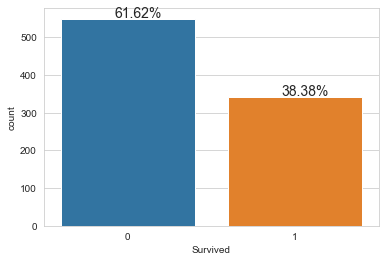

In [9]:
s = sns.countplot(x ="Survived",
              data =train)
for p in s.patches:
    print(p)
    s.text(x=p.get_x()  + p.get_width()/2.5,
           y = p.get_height() + 3 ,
           s = f"{(p.get_height() / len(train) *100):.2f}%",
           fontsize = 14)

Here:
* 0: Did not Survive while
* 1: Survived.

Clearly, less people survived the accident.

# Detecting Missing value

## Detecting the missing value numerically

> The first step is detect the count/percentage of missing value in every column of the dataset . This will give the idea about the distribution of missing value

In [10]:
def missing_value_table(df):
    missing_value_table_df = pd.DataFrame(index=df.columns,
                                          columns=["count","percentage"],)
    for col in df.columns:

        # total missing value
        missing_value_table_df.loc[col,"count"] = df[col].isnull().sum()

        #percentage of missing value

        missing_value_table_df.loc[col,"percentage"] = df[col].isnull().sum()/df[col].size * 100

    missing_value_table_df =missing_value_table_df.replace(0,np.nan).dropna()
    print(f"Your dataframe contain {len(df.columns)} columns .")
    print(f"There are {len(missing_value_table_df.index)} columns that have missing value")

    return missing_value_table_df

In [11]:
missing_value_table(train)

Your dataframe contain 12 columns .
There are 3 columns that have missing value


,count,percentage
Age,177.0,19.865320
Cabin,687.0,77.104377
Embarked,2.0,0.224467


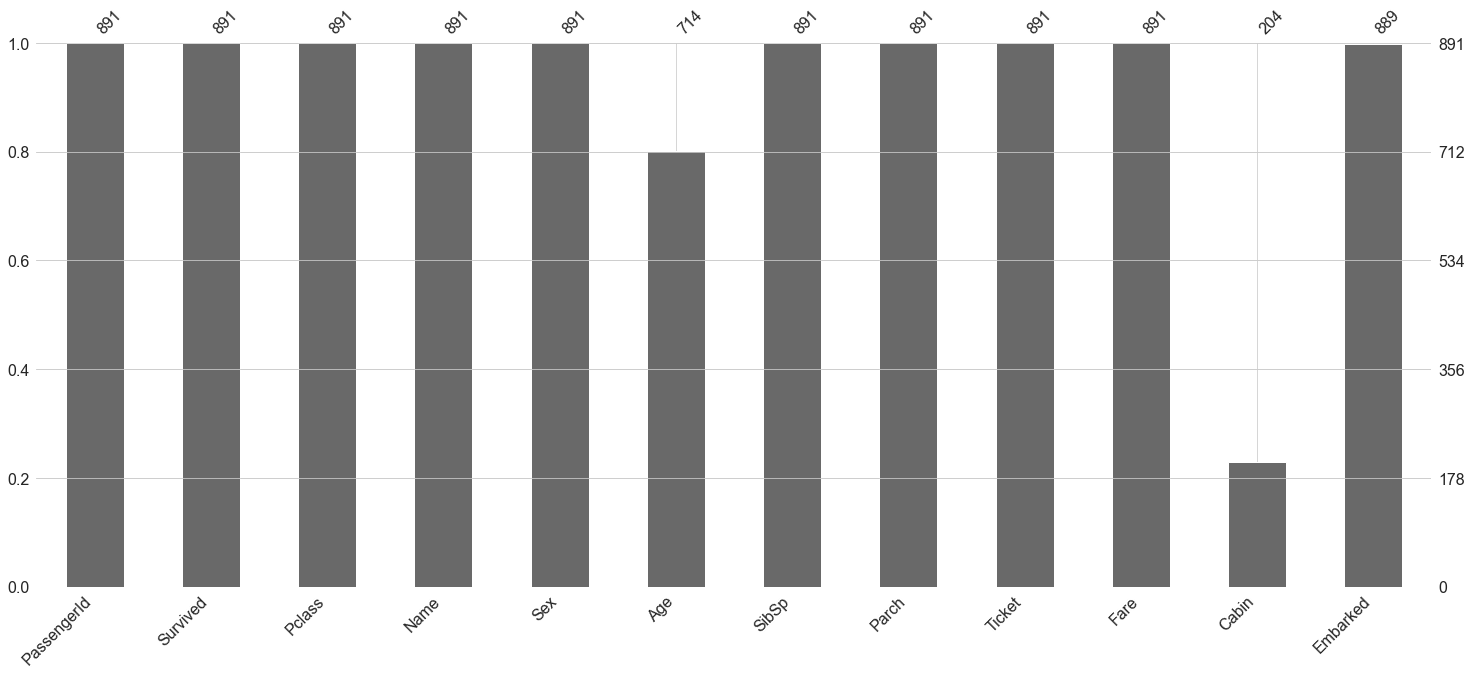

In [12]:
msno.bar(train);

> The Bar chart above give the graphical overview of completeness of the dataset . We can see that age,cabin,embarked column have missing values.Next , we would like to find the location of the missing values in the dataset


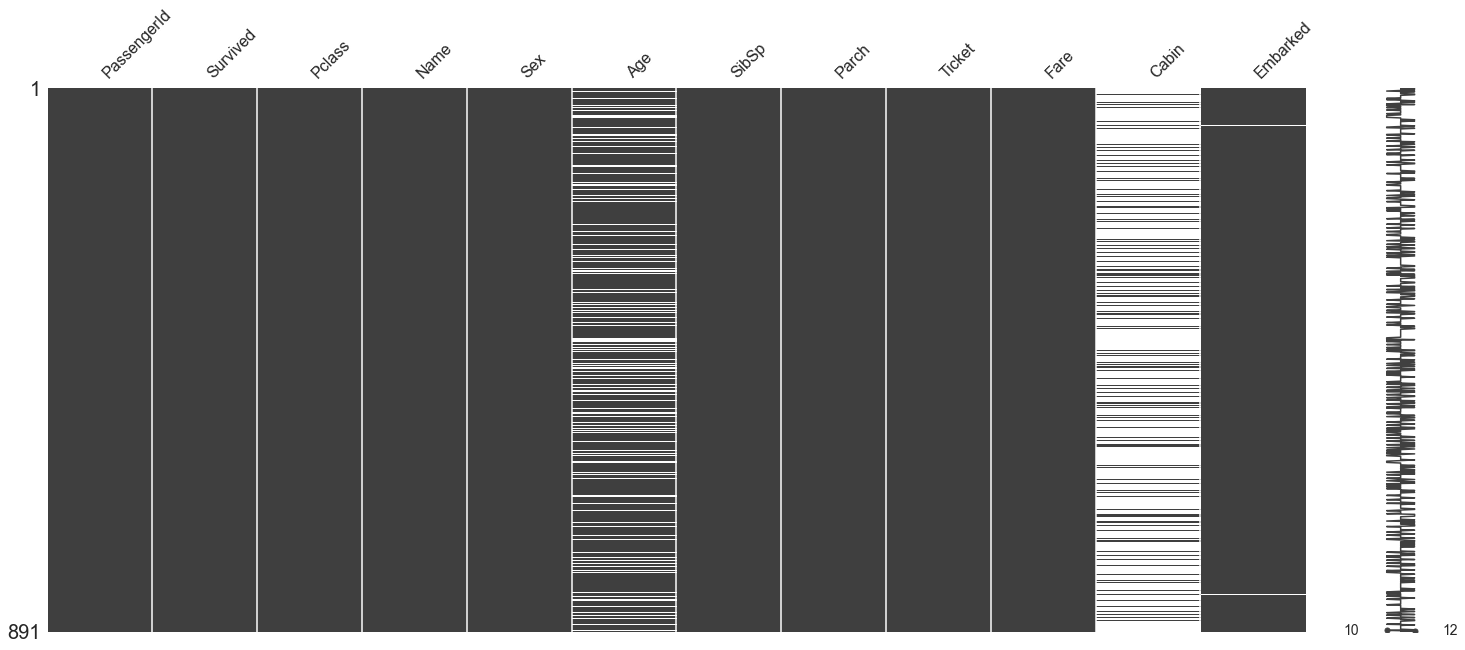

In [13]:
msno.matrix(train);

# Reasons for Missing Values

>Before we start treating the missing values ,it is important to understand the various reasons for the missingness in data. Broadly speaking, there can be three possible reasons:

<img src="https://cjasn.asnjournals.org/content/clinjasn/early/2014/02/06/CJN.10141013/F2.large.jpg?width=800&amp;height=600&amp;carousel=1" width="1000"/>



**1. Missing Completely at Random (MCAR)**

>The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

**2. Missing at Random (MAR)**

>MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.

**3. Missing Not at Random (MNAR)**
>Missingness depends on unobserved data or the value of the missing data itself.




>Now let us look at nullity matrix again to see if can find what type of missingness is present in the dataset.

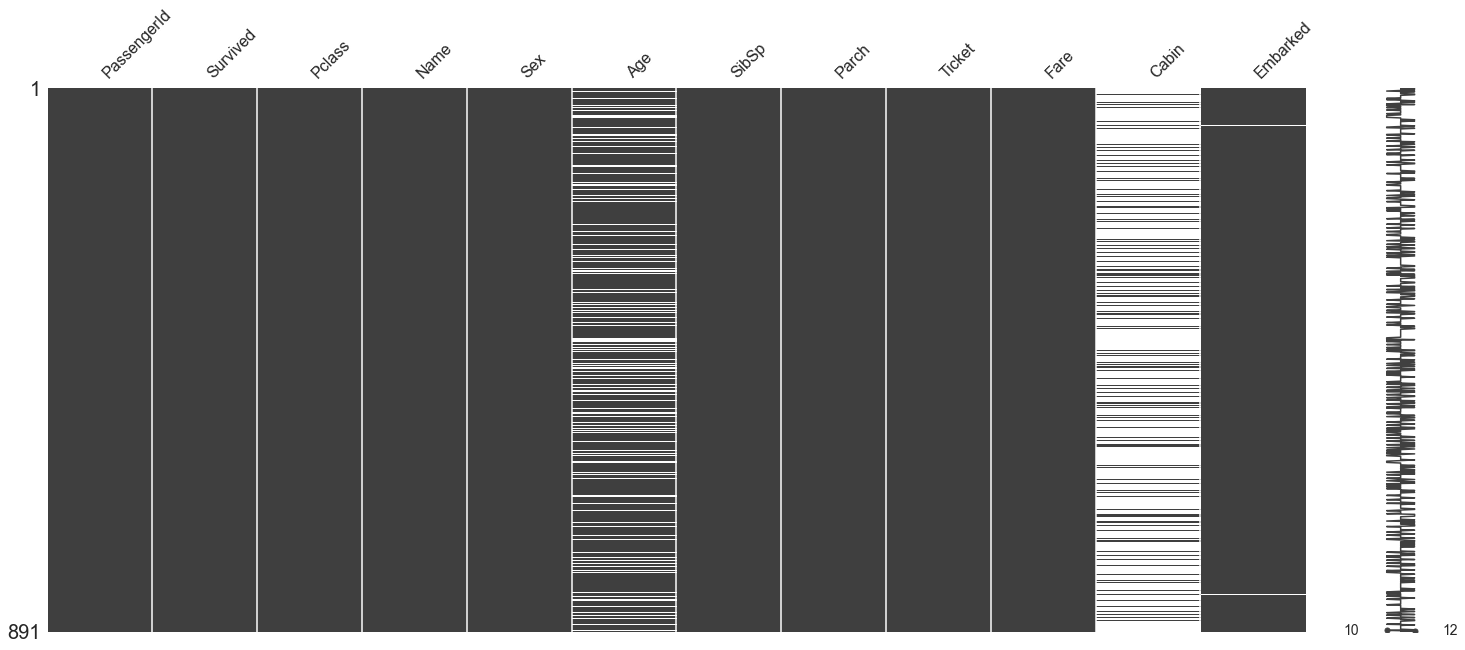

In [14]:
msno.matrix(train);

> The **`Embarked`** column has very few missing value and don't seem to be correlated with other missing variable.So we conclude that Embarked column as the `Missing Complete at Random`
>
>
> Both `Age` and `Cabin` column has the lot of missing values.This could be case of the `Missing at Random` as we cannot directly observe the reason for missingness of data in these column.
>

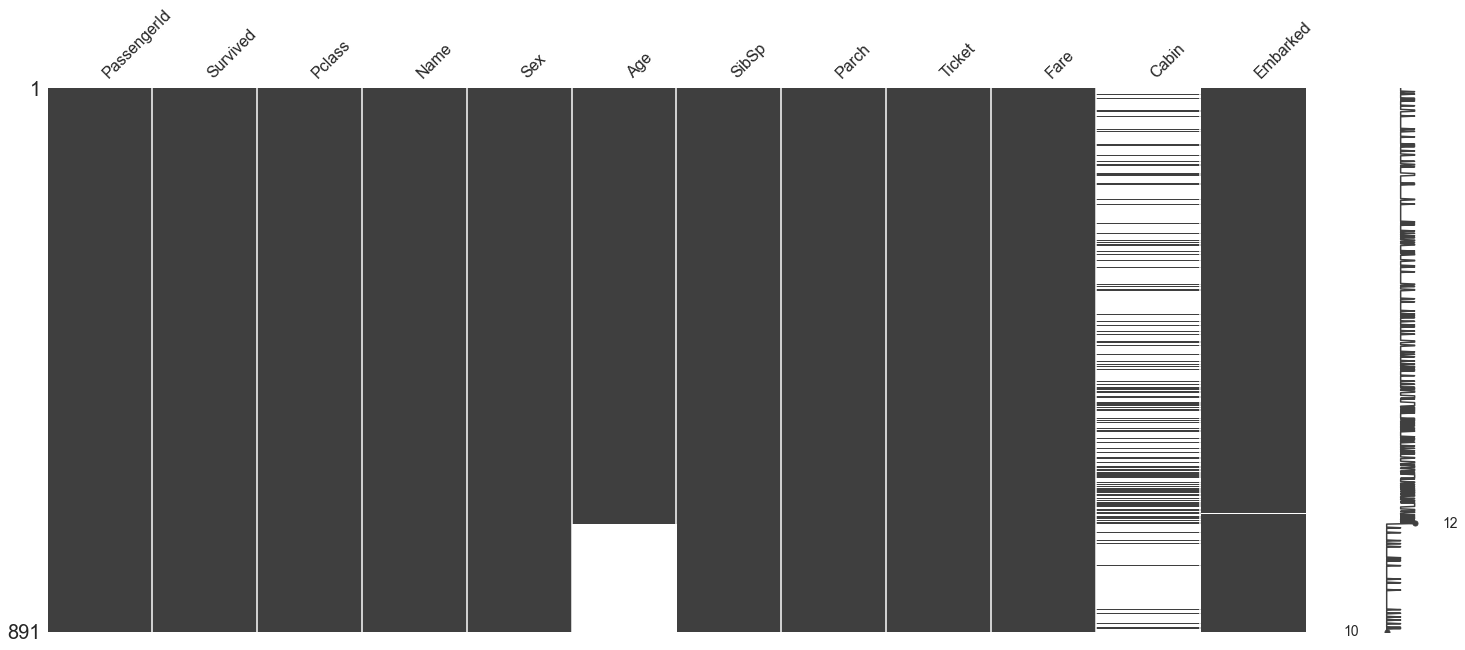

In [15]:
msno.matrix(train.sort_values("Age"));

it is clear that here is no relation between the missingness of age and Cabin.To provide the more evidence for this we will plot the heatmap

<AxesSubplot:>

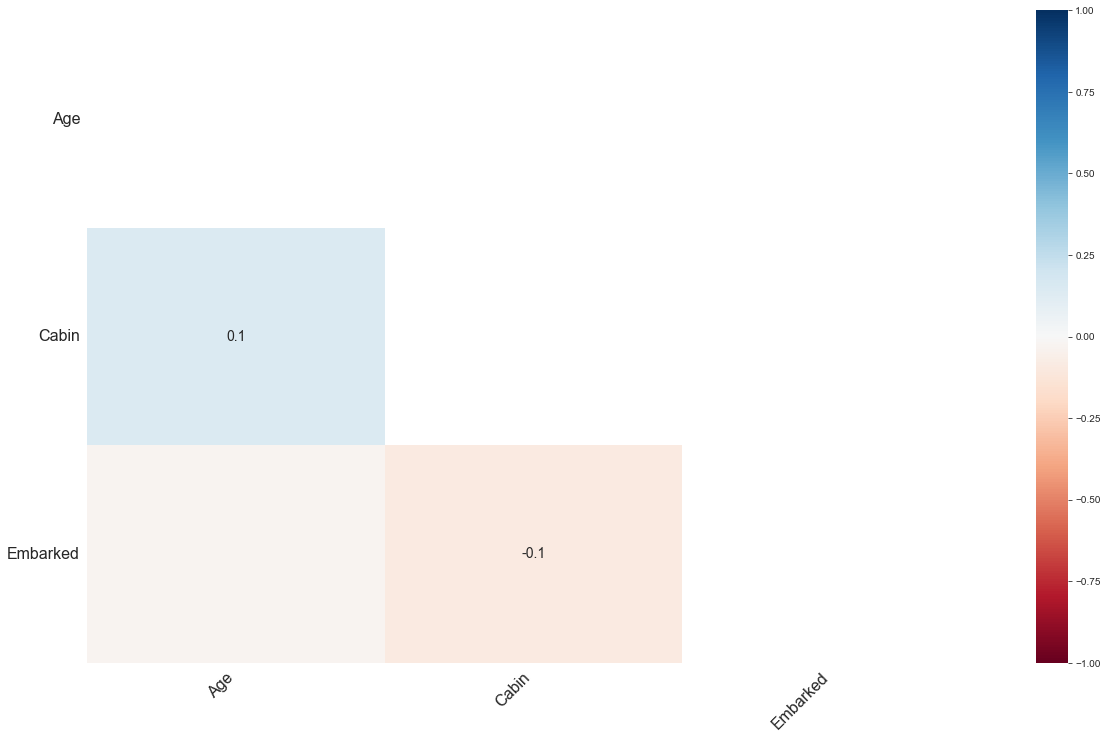

In [16]:
msno.heatmap(train)

The heatmap show that there is less correlation between the age and cabin.low correlation futher strengthen that Age and Cabin are **Missing at Random**

<AxesSubplot:>

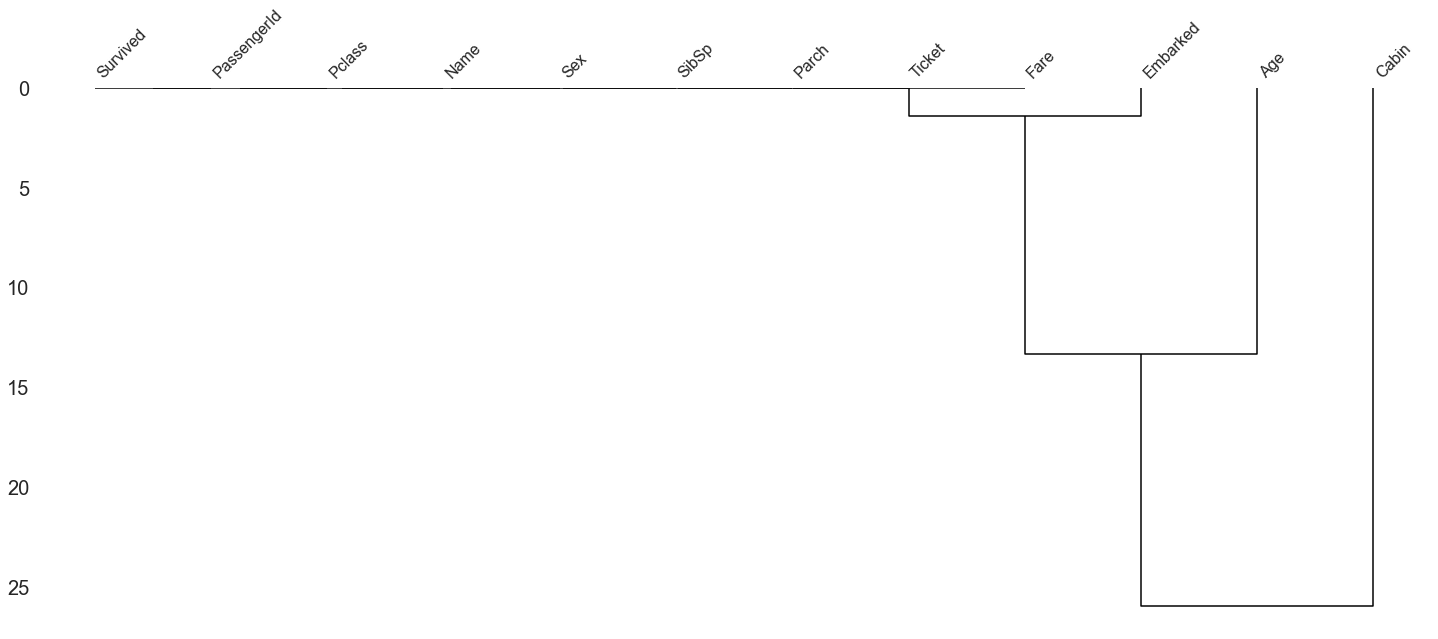

In [17]:
msno.dendrogram(train)

#  Visualise the missing value


In [25]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [20]:
def fill_dummy_values(df,scaling_factor = 0.075):
    dummy_df = df.copy(deep=True)
    for col in dummy_df.columns:

        """For Each column
                1. Taking the only null values.
                2. Finding the number of nulls.
                3. Calculating the range of column"""

        column = dummy_df[col]
        col_nulls = column.isna()
        num_nulls = col_nulls.sum()
        col_range = column.max() - column.min()

        """1. Generating the random value from the uniform distribution.
           2. Since the uniform distribution rang form [0,1] , we need the scale the distribution such range become [-2,-1]
           """
        dummy_values = np.random.rand(num_nulls) - 2
        dummy_values = dummy_values * scaling_factor * col_range + column.min()

        dummy_df.loc[col_nulls,col] = dummy_values

    return dummy_df







In [21]:
dummy_train = fill_dummy_values(train)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

array([-1.4063923 , -1.20436192, -1.91579146, -1.38314774, -1.33388463,
       -1.70155141, -1.33701497, -1.41805865, -1.91246259, -1.47026977,
       -1.38996355, -1.11001623, -1.29545108, -1.7690748 , -1.96991853,
       -1.17131086, -1.22713468, -1.43533823, -1.22791948, -1.88972811,
       -1.83633591, -1.0764403 , -1.02620962, -1.54100842, -1.50443573,
       -1.08731667, -1.88846236, -1.42209222, -1.24768643, -1.97437012,
       -1.43068342, -1.19583383, -1.03304601, -1.5919697 , -1.15523383,
       -1.05804375, -1.53819619, -1.86630397, -1.4986579 , -1.85511622,
       -1.84236045, -1.89531541, -1.74857185, -1.09723886, -1.92850954,
       -1.5231921 , -1.53690242, -1.03043254, -1.58488184, -1.04946448])

# Treating the Missing Values

After identified the missing value we need to treat them .


## Deletions

![](https://imgur.com/tBvdfyX.png)

>Deletion mean to deleted teh  missing value from  a dataset .However, this is not recommended as it might result in loss of information from the dataset .We should only delete if the missing value probation is small in the dataset.

### Pairwise Deletion

> Pairwise deletion is used when the value are **Missing Completely at random** (MCAR) .During pairwise deletion only the missing value is deleted .All the operation in the pandas like mean ,sum ,etx intrinsically skip missing values.